This file contains the code to find the most suitable K value for the KNN filling algorithm
Since Logistic regression performs and worst among all algorithm, we don't use it here

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
# Cross Validation Classification Accuracy
from pandas import read_csv
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn import preprocessing 
from sklearn.impute import KNNImputer
# from sklearn.neighbors import KNeighborsClassifier
#import faiss
from numpy import isnan
#import matplotlib.pyplot as plot
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
from sklearn import tree
import statistics
import time
import warnings
warnings.filterwarnings('ignore')
# plotting errorbar graph for visual representation of the performance of the classifiers
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
import random
from xgboost import XGBClassifier
import shutil
import os
from os import path
import ipynb.fs.full.our_functions_library as flib
from our_evaluate_sepsis_score import evaluate_performance

In [15]:
# Global initialization, get all the data from file and generate all the needed variable
filename = 'raw_data/raw_data_400.csv' # use raw dataset
#filename = 'data.csv' # use raw dataset
originalData = read_csv(filename) # read csv data into DataFrame var raw
print("Data size:",originalData.shape)
Original_Uniq_ID= np.unique(originalData['Patient_id']) 
Uniq_ID = Original_Uniq_ID.copy()
print('Patient id size:',len(Uniq_ID))
X_columns = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2','BaseExcess', 'HCO3', 'FiO2', 'pH', 
             'PaCO2', 'SaO2', 'AST', 'BUN','Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
             'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium','Bilirubin_total', 'TroponinI', 'Hct', 
             'Hgb', 'PTT', 'WBC','Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2','HospAdmTime',
             'ICULOS', 'Patient_id', 'time']
y_columns = ['Patient_id', 'SepsisLabel']
# Initialize the empty array X_train, X_test, y_train, y_test
X_train = pd.DataFrame(columns = X_columns)
X_test = pd.DataFrame(columns = X_columns)
y_train = pd.DataFrame(columns = y_columns)
y_test = pd.DataFrame(columns = y_columns)
# Below are the lists for KNN results

KNN_UtilityScore_mean = []
KNN_UtilityScore_std = []

KNN_F1Score_mean = []
KNN_F1Score_std = []

KNN_auroc_mean = []
KNN_auprc_mean = []

KNN_accuracy_mean = []
KNN_accuracy_std = []

KNN_positiveprediction_mean = []
KNN_baseline_mean = [ ]
KNN_total_Time= [ ]


fillmethod =""  

Data size: (15348, 43)
Patient id size: 400


In [16]:
#This block will shuffle the id sets of patients in a fix manner, so for every time you run the code, the dataset and trainset are always the same.
seed = 2
random.seed(seed)
if(np.array_equal(Original_Uniq_ID,Uniq_ID) ):
    print("They are the same. Uniq id hasn't been shuffled, and it will be shuffeld now.")   
    random.shuffle(Uniq_ID)# randomly sorted the patient IDs    
else:
    print("They are not the same. Uniq_id has already been shuffled.")    
print("The original uniq id set is:\n",Original_Uniq_ID[0:25])
print("Uniq id:************************************")
print("The fixed shuffelld id set, it should be 211 275 153 189 184 110 124  49 345...\n",Uniq_ID[0:25])

They are the same. Uniq id hasn't been shuffled, and it will be shuffeld now.
The original uniq id set is:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Uniq id:************************************
The fixed shuffelld id set, it should be 211 275 153 189 184 110 124  49 345...
 [211 275 153 189 184 110 124  49 345  73 284  20  71 328 136 241 171 141
 329 204 157 290 305 281 323]


In [17]:
#fill the missing data with one function
print(filename)
print(len(Original_Uniq_ID))
#print(originalData)
if (originalData.isnull().values.any()):
    print('There is data missing in the original data set')
dataByPatient = originalData.groupby('Patient_id') # data grouped by Patient_id

raw_data/raw_data_400.csv
400
There is data missing in the original data set


In [18]:
def Average(lst): 
    return sum(lst) / len(lst) 

#this function will clear everything in the trainng and test dataset
def clearAllDatasets():
    global X_train, X_test, y_train, y_test
    if not X_train.empty: 
        X_train = X_train[0:0]
    if not X_test.empty:
        X_test = X_test[0:0]
    if not y_train.empty:
        y_train = y_train[0:0]
    if not y_test.empty:
        y_test = y_test[0:0]
    
def printDataset():
    print('X train shape:',X_train.shape)
    print(X_train)
    print( 'Y train shape:',y_train.shape)
    print(y_train)
    print('X test shape:',X_test.shape)
    print(X_test)
    print( 'Y test shape:',y_test.shape)
    print(y_test)
    
def printDatasetType():
    print('X_train type:',type(X_train),'y_train type:',type(y_train) )
    print('X test shape:',type(X_test),'Y test shape:',type(y_test) )
    print('X_train data type:',(X_train.dtypes),'y_train data type:',(y_train.dtypes) )
    print('X_test data type:',(X_test.dtypes),'Y_test data type:',(y_test.dtypes) )
    
def KNN_reset():
    #KNN with different K size, 
    KNN_UtilityScore_mean.clear()
    KNN_UtilityScore_std.clear()
    KNN_F1Score_mean.clear()
    KNN_F1Score_std.clear()
    KNN_auroc_mean.clear()
    KNN_auprc_mean.clear()
    KNN_accuracy_mean.clear()
    KNN_accuracy_std.clear()
    KNN_positiveprediction_mean.clear()
    KNN_baseline_mean.clear()
    KNN_total_Time.clear()
    
def generateTrainDataSet(patienIds):
    global X_train, y_train
    for i in patienIds:
#     print('Patient_id',i,':\n',dataByPatient.get_group(i),'\n')
        X_train = X_train.append(dataByPatient.get_group(i).loc[:, X_columns])
        y_train = y_train.append(dataByPatient.get_group(i).loc[:, y_columns])
    return X_train, y_train
 
def generateTestDataSet(patienIds):
    global X_test, y_test
    for i in patienIds:
#     print('Patient_id',i,':\n',dataByPatient.get_group(i),'\n')
        X_test = X_test.append(dataByPatient.get_group(i).loc[:, X_columns])
        y_test = y_test.append(dataByPatient.get_group(i).loc[:, y_columns]) 
    return X_test, y_test

#Functions below are filling the missing data
#This function perform the KNN missing data filling for 
# import numba as nb
# @nb.jit
def KNNfilling(trainData,testData,K= 5, fillmethod=""):
    imputer = KNNImputer(n_neighbors = K)
    #imputer = FaissKNeighbors(k=K)
    # fit 
    imputer.fit(trainData)
    #transfer
#     x_train_impute=imputer.transform(trainData).round(3)
#     x_test_impute=imputer.transform(testData).round(3)
    x_train_impute=imputer.transform(trainData)
    x_test_impute=imputer.transform(testData)
    fillmethod= "KnnFill"
    return x_train_impute, x_test_impute, fillmethod   #This may cause error when the data is very large in size

def CalculateSOFAScore(X_train_impute, X_test_impute):
    pass


In [19]:
def WriteToFiles(X_test_impute,y_test, NFold, fillmethod):
    x= pd.DataFrame(data=X_test_impute, columns=X_columns)
    y= pd.DataFrame(data=y_test, columns=y_columns)
    # tot= x.join(y)
    x.merge(y, how='inner', on='Patient_id')
    patient_size=np.unique(x['Patient_id'])
#     print(patient_size)
#     print(int(patient_size[2]))
    dirName=r'C:\Users\r0631\Documents\K-Fold\filled_data/'+str(fillmethod)+'/Fold'+str(NFold+1)
    if os.path.exists(dirName):
        shutil.rmtree(dirName)  # remove existing directory
    os.makedirs(dirName)
    for ind in range(len(patient_size)):
        #filename=r'output/Fold'+str(NFold+1)+'/p'+str(ind)+'.psv'
        id =int(patient_size[ind])
        filename=dirName+'/p'+str(id)+'.psv'
        patient = x.loc[x['Patient_id'] == id]
        patient.to_csv (filename, index = False, header=True, sep='|')
    print('Fold',NFold,'written away')
    
def CalcMean_Std (Data):
    print(Data)
    mean= np.mean(Data, axis=0)
    np.set_printoptions(precision=3, suppress=True)
    print('numpy mean\n',mean)
    Data_std = Data.std(axis = 0) 
    print('Data_mean\n',Data_std.round(3))
    
def plotKNNResultFigure(KValuestart,KvalueEnd,yValues,title,xlabel,ylabel):
    plt.figure(figsize=(10,6))
    plt.plot(range(KValuestart,KvalueEnd+1,5),yValues,color = 'blue',linestyle='dashed', 
             marker='o',markerfacecolor='red', markersize=10)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    print("Maximum ",ylabel,":-",max(yValues),"at K =", 1 + yValues.index(max(yValues)))
    

In [26]:
# Code for K-fold algorithm, Before this step the missing data has been filled, 
def KFold_patient(model, KforKFold=10,KforKNN=5, fillmethod=""):
    start = time.time()# time indicator for how long the Kfold func takes
    global X_train, X_test, y_train, y_test
    print("K Fold of ",KforKFold ," folds with KNN =",KforKNN)
    # initialisation of the array for storing the different intermediate results
    accuracy_model = []
    F1Score_model = []
    baseline_model= []
    auroc_model = []
    auprc_model = []
    physio_accuracy_model = []
    f_measure_model = []
    utility_score_model = []
    mean_train = 0
    positivepredictions = []
    #The unique id sets have been created and shuffled in a fix manner in the third block, you can just use it here and no more any other manipulation
    idSets = np.array_split(Uniq_ID, KforKFold)# divide the ids into K groups
    #print("Patients number: ", len(Uniq_ID)) #print('idSets arrays',idSets)
    #This for loop is for Kfold, calculating the results for K times
    for i in range(KforKFold):
        start1 = time.time()
        clearAllDatasets() #first clear all the datasets
        print("for the",i+1,"th iteration",idSets[i])   
        X_test,y_test = generateTestDataSet(idSets[i])
        for j in range(KforKFold):
            if j != i:
                 X_train, y_train = generateTrainDataSet(idSets[j]) 
        #printDataset()
        #Now the train and test dataset is generated
        #we can begin to train the model wit the training set and evaaulate the performance with the test sett   
#         X_train = X_train.drop('time', 1) X_test = X_test.drop('time', 1)
        X_train=X_train.astype('float64')
        X_test=X_test.astype('float64')    
        YTest_copy = y_test  # variable of joining the filled data (X) and Y (Train_output) 
        patientID_ytest = y_test['Patient_id']
        y_train = y_train.drop('Patient_id', 1)
        y_test = y_test.drop('Patient_id', 1)      
        y_train=y_train.astype('float64')
        y_test=y_test.astype('float64')
        #print('YTest',YTest_copy.head())
        
        #fill the missing data
        if X_train.isnull().values.any() or X_test.isnull().values.any() :
            print("X_train or X_test contains NaN values, KNN/mean is performed.")
            #if there is missing value
            X_train_impute, X_test_impute, fillmethod = KNNfilling(X_train, X_test, KforKNN, fillmethod)
            #X_train_impute, X_test_impute,fillmethod = MeanFilling(X_train,X_test, fillmethod)            
        else:
            print("X_train or X_test have all been filled ")
            X_train_impute = X_train
            X_test_impute = X_test
            
        #Scale the data
#         scaler = preprocessing.StandardScaler()
#         scaler.fit(X_train_impute)
#         X_train_impute = scaler.transform(X_train_impute)
#         X_test_impute = scaler.transform(X_train_impute)
            
        #fit the model and predict
        model.fit(X_train_impute, y_train)
        y_predicted = model.predict(X_test_impute)   
        y_predicted_probobility = model.predict_proba(X_test_impute) 
        #transfer the outpu and evalute it
        y_labels = y_test.astype(int).to_numpy()
        y_predicted = y_predicted.astype(int)
        y_predicted_probobility =  y_predicted_probobility[:,1].round(4)
        #print(y_labels)
        
#         # parameter for gridsearchcv
#         param_dict={
#             "criterion":['gini', 'entropy'],
#             "max_depth":range(1,10),
#             "min_samples_split":range(1,10),
#             "min_samples_leaf":range(1,5)
#         }
        
#         # finding best hyperparameter using gridsearchcv
#         grid=GridSearchCV(estimator=decision_tree,
#                           param_grid=param_dict,
#                           cv=10,
#                           verbose=1,
#                           n_jobs=-1)
#         grid.fit(X_train, y_train)
#         print("best_params:",grid.best_params_,"best_score",grid.best_score_,"\n")
       
        auroc, auprc, physio_accuracy, f_measure, utility_score = evaluate_performance(y_labels, y_predicted, y_predicted_probobility,patientID_ytest)
#         print("\nauroc",round(auroc,4),"auprc",round(auprc,4),"util_accuracy",round(accuracy1,4))
#         print("f_measure",round(f_measure,4),"utility_score",round(utility_score,4))  
        auroc_model.append(round(auroc,4))
        auprc_model.append(round(auprc,4))
        physio_accuracy_model.append(round(physio_accuracy,4))
        f_measure_model.append(round(f_measure,4))
        utility_score_model.append(round(utility_score,4))
        positivepredictions.append(np.sum(y_predicted))

#       num_rows= X_test_impute.shape[0]
#       scores = np.zeros(num_rows).astype('float64')# score parameter:output from get_sepsis_score
#       labels = np.zeros(num_rows).astype('float64')
        #WriteToFiles(X_train_impute,YTest_copy,i, fillmethod)
        #CalcMean_Std(X_train_impute)
        #take down the results
        accuracy_model.append((accuracy_score(y_test, y_predicted, normalize=True)*100).round(2))
        F1Score_model.append((f1_score(y_test, y_predicted)*100).round(2))
        baseline_model.append(round( (1 - float(y_test.mean()) )*100 , 2 ))
        #print("\ny_test size:",y_test.shape, '1´s in y_test',y_test.sum())
        #baseline_model.append(((1-y_test.mean())*100).round(2))
        #print("The number of 1 (SepsisLabel) in this prediction: ", np.sum(y_predicted))
    #     print(accuracy_model)
    #     print(F1Score_model)    
        end1 = time.time()
        print("Time spent in this KFold iteration",round(end1- start1,2),"sec.\n")
        print("******************************************************************")
    print('Accuracy model:', accuracy_model)
    print('F1_score model:', F1Score_model)
    print('Baseline model:', baseline_model)
    
    print("\nEvaluation parameters of the utiltiy evaluation function:")
    print('auroc of model:', auroc_model)
    print('auprc of model:', auprc_model)
    print('Utility accuracy of model:', accuracy_model)
    print('utility F1 of model:', f_measure_model)
    print('Utility score of model:', utility_score_model)
    
    KNN_UtilityScore_mean.append(np.mean(utility_score_model))
    KNN_UtilityScore_std.append(np.std(utility_score_model))
    
    KNN_F1Score_mean.append(np.mean(f_measure_model))
    KNN_F1Score_std.append(np.std(f_measure_model))
    
    KNN_auroc_mean.append(np.mean(auroc_model))
    KNN_auprc_mean.append(np.mean(auprc_model))
    
    KNN_accuracy_mean.append(np.mean(physio_accuracy_model))
    KNN_accuracy_std.append(np.std(physio_accuracy_model))
    
    KNN_positiveprediction_mean.append(np.mean(positivepredictions))
    KNN_baseline_mean.append(np.mean(baseline_model))
    totalTime=round(time.time()- start,2)
    KNN_total_Time.append(totalTime)
    
    print("\nTotal Time spent in  KFold function",totalTime,"sec.\n")


In [21]:
def Print_DATA():
    print("KNN_UtilityScore_mean",KNN_UtilityScore_mean)
    print("KNN_UtilityScore_std",KNN_UtilityScore_std)
    print("KNN_F1Score_mean",KNN_F1Score_mean)
    print("KNN_F1Score_std",KNN_F1Score_std)
    print("KNN_auroc_mean",KNN_auroc_mean)
    print("KNN_auprc_mean",KNN_auprc_mean)
    print("KNN_accuracy_mean",KNN_accuracy_mean)
    print("KNN_accuracy_std",KNN_accuracy_std)
    print("KNN_positiveprediction_mean",KNN_positiveprediction_mean)
    print("KNN_baseline_mean",KNN_baseline_mean)
    
    print(len(KNN_accuracy_mean))
    print(len(KNN_accuracy_std))
    print(len(KNN_F1Score_mean))
    print(len(KNN_F1Score_std))
    print(len(KNN_positiveprediction_mean))

def displayCurrentResult(KforKNNstart, KforKNNend):
    print((KNN_accuracy_mean))
    print((KNN_accuracy_std))
    print((KNN_F1Score_mean))
    print((KNN_F1Score_std))
    print((KNN_positiveprediction_mean))
    print(len(KNN_accuracy_mean))
    print(len(KNN_accuracy_std))
    print(len(KNN_F1Score_mean))
    print(len(KNN_F1Score_std))
    print(len(KNN_positiveprediction_mean))
    plotKNNResultFigure(KforKNN,KNN_accuracy_mean,"Mean Accuracy vs K",xlabel='K',ylabel="Mean Accuracy")
    plotKNNResultFigure(KforKNN,KNN_accuracy_std ,"Std of Accuracy vs K",xlabel='K',ylabel="Std of Accuracy")
    plotKNNResultFigure(KforKNN,KNN_F1Score_mean,"Mean F1 score vs K",xlabel='K',ylabel="Mean F1 score")
    plotKNNResultFigure(KforKNN,KNN_F1Score_std,"Std F1 score vs K",xlabel='K',ylabel="Std F1 score")
    plotKNNResultFigure(KforKNN,KNN_positiveprediction_mean,"Mean positive prediction vs K",xlabel='K',ylabel="Mean positive prediction") 
   
def findBestKforKNN(model, KforKFold=10,KforKNNstart=1,KforKNNend=10, stepsize=5):
    if(KforKNNend<=1):
        print("K must be a interger larger than 1")
        return
    KNN_reset()
    step=stepsize
    for i in range(KforKNNstart,KforKNNend+1,step) : 
        print("KNN of K = ",i)    
        KFold_patient(model,10,i)
    print("Now all the training is finished.")
    plotKNNResultFigure(KforKNNstart,KforKNNend,KNN_UtilityScore_mean,"Mean Utility Score vs K",xlabel='K',ylabel="mean Utility Score")
    plotKNNResultFigure(KforKNNstart,KforKNNend,KNN_UtilityScore_std,"std Utility Score vs K",xlabel='K',ylabel="std Utility Score")
    plotKNNResultFigure(KforKNNstart,KforKNNend,KNN_F1Score_mean,"Mean F1 score vs K",xlabel='K',ylabel="Mean F1 score")
    plotKNNResultFigure(KforKNNstart,KforKNNend,KNN_F1Score_std,"Std F1 score vs K",xlabel='K',ylabel="Std F1 score")
    plotKNNResultFigure(KforKNNstart,KforKNNend,KNN_accuracy_mean,"Mean Accuracy vs K",xlabel='K',ylabel="Mean Accuracy")    

In [22]:
#fill the missing data with one function
print(filename)
#print(originalData)
if (originalData.isnull().values.any()):
    print('Data isn´t all filled before K-Fold Func')
dataByPatient = originalData.groupby('Patient_id') # data grouped by Patient_id

raw_data/raw_data_400.csv
Data isn´t all filled before K-Fold Func


In [23]:
Print_DATA()

KNN_UtilityScore_mean []
KNN_UtilityScore_std []
KNN_F1Score_mean []
KNN_F1Score_std []
KNN_auroc_mean []
KNN_auprc_mean []
KNN_accuracy_mean []
KNN_accuracy_std []
KNN_positiveprediction_mean []
KNN_baseline_mean []
0
0
0
0
0


In [40]:
#Here is how to train the model
#logisticRegressionModel = LogisticRegression(C=0.1,random_state=2,solver='saga', max_iter=1000,penalty='l1')
logisticRegressionModel = LogisticRegression(C=0.1,random_state=2,solver='lbfgs', max_iter=1000)
decisionTreeModel = tree.DecisionTreeClassifier(random_state=2, class_weight="balanced")
randomForestModel = RandomForestClassifier(random_state=2)
XGBoostModel = XGBClassifier(random_state=2)
#AdaBoostModel = AdaBoostClassifier(random_state=2)

In [41]:
KFold_patient(decisionTreeModel,10,5)

K Fold of  10  folds with KNN = 5
for the 1 th iteration [211 275 153 189 184 110 124  49 345  73 284  20  71 328 136 241 171 141
 329 204 157 290 305 281 323  57 208  41 366 220 120 118 244  22 325 222
 178 369 381  52]
X_train or X_test contains NaN values, KNN/mean is performed.
Time spent in this KFold iteration 107.2 sec.

******************************************************************
for the 2 th iteration [ 50 379 363 326 248 348 169 319 149 210 113  77 352 342 292 324 309 285
 310  32 320 332 331 144 223 151  69 216 321 276 102 249 283  46  38 245
 376  61 289 146]
X_train or X_test contains NaN values, KNN/mean is performed.
Time spent in this KFold iteration 70.14 sec.

******************************************************************
for the 3 th iteration [ 28 360 341 278 225 273 218  90 227  16 393  45  18 230  92  51 307  74
 207 252 116  97 236 111 337 240  48   4 219 267 174 280  76 392 162  63
 385  53 255 238]
X_train or X_test contains NaN values, KNN/mean is pe

In [ ]:
#random_State=2
# Accuracy model: [95.83, 92.21, 92.12, 95.05, 97.04, 81.35, 90.89, 97.42, 97.38, 96.77]
# F1_score model: [17.95, 4.41, 13.56, 2.47, 31.58, 5.39, 2.76, 28.07, 9.09, 8.16]
# Baseline model: [96.87, 99.04, 95.67, 97.06, 99.32, 98.41, 98.19, 98.17, 98.1, 97.92]

# Evaluation parameters of the utiltiy evaluation function:
# auroc of model: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# auprc of model: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
# Utility accuracy of model: [95.83, 92.21, 92.12, 95.05, 97.04, 81.35, 90.89, 97.42, 97.38, 96.77]
# utility F1 of model: [0.1795, 0.0441, 0.1356, 0.0247, 0.3158, 0.0539, 0.0276, 0.2807, 0.0909, 0.0816]
# Utility score of model: [0.1297, -0.051, 0.1175, -0.002, 0.8935, 0.0092, -0.0333, 0.231, 0.0443, 0.046]


# random_stat=2'max_depth': 1,'min_samples_leaf': 1, 'min_samples_split': 2
# Accuracy model: [96.87, 99.04, 95.67, 97.06, 99.32, 98.41, 98.19, 98.17, 98.1, 97.92]
# F1_score model: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# Baseline model: [96.87, 99.04, 95.67, 97.06, 99.32, 98.41, 98.19, 98.17, 98.1, 97.92]

# Evaluation parameters of the utiltiy evaluation function:
# auroc of model: [0.7564, 0.9283, 0.5521, 0.6389, 0.4954, 0.7051, 0.6641, 0.8042, 0.6627, 0.6552]
# auprc of model: [0.2184, 0.0632, 0.0546, 0.0806, 0.0068, 0.0322, 0.0778, 0.1416, 0.1009, 0.3247]
# Utility accuracy of model: [96.87, 99.04, 95.67, 97.06, 99.32, 98.41, 98.19, 98.17, 98.1, 97.92]
# utility F1 of model: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
# Utility score of model: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Accuracy model: [95.77, 85.13, 90.65, 93.98, 97.95, 73.43, 94.83, 93.83, 96.0, 98.06]
# F1_score model: [44.44, 11.43, 12.95, 23.81, 0.0, 7.41, 20.0, 27.94, 24.69, 42.55]
# Baseline model: [96.87, 99.04, 95.67, 97.06, 99.32, 98.41, 98.19, 98.17, 98.1, 97.92]

# Evaluation parameters of the utiltiy evaluation function:
# auroc of model: [0.7564, 0.9249, 0.5505, 0.6389, 0.4931, 0.701, 0.6582, 0.7994, 0.6584, 0.6695]
# auprc of model: [0.2184, 0.0606, 0.0537, 0.0806, 0.0068, 0.0315, 0.0612, 0.1226, 0.0788, 0.2052]
# Utility accuracy of model: [95.77, 85.13, 90.65, 93.98, 97.95, 73.43, 94.83, 93.83, 96.0, 98.06]
# utility F1 of model: [0.4444, 0.1143, 0.1295, 0.2381, 0.0, 0.0741, 0.2, 0.2794, 0.2469, 0.4255]
# Utility score of model: [0.5365, 0.5735, 0.1281, 0.2819, -0.0581, 0.2135, 0.3188, 0.5782, 0.3271, 0.3317]


In [28]:
Print_DATA()

KNN_UtilityScore_mean [0.32312]
KNN_UtilityScore_std [0.19247654818184992]
KNN_F1Score_mean [0.21522000000000002]
KNN_F1Score_std [0.13652335184868558]
KNN_auroc_mean [0.68503]
KNN_auprc_mean [0.09194]
KNN_accuracy_mean [0.91963]
KNN_accuracy_std [0.07151697770459825]
KNN_positiveprediction_mean [127.2]
KNN_baseline_mean [97.875]
1
1
1
1
1


In [13]:
findBestKforKNN(decisionTreeModel,10,5,15)

KNN of K =  5
K Fold of  10  folds with KNN = 5
for the 1 th iteration [211 275 153 189 184 110 124  49 345  73 284  20  71 328 136 241 171 141
 329 204 157 290 305 281 323  57 208  41 366 220 120 118 244  22 325 222
 178 369 381  52]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1535, 1) 1´s in y_test SepsisLabel    48.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  12
Time spent in this KFold iteration 80.2 sec.

******************************************************************
for the 2 th iteration [ 50 379 363 326 248 348 169 319 149 210 113  77 352 342 292 324 309 285
 310  32 320 332 331 144 223 151  69 216 321 276 102 249 283  46  38 245
 376  61 289 146]
X_train or X_test contains NaN values, KNN/mean is performed.


KeyboardInterrupt: 

In [14]:
Print_DATA()

KNN_UtilityScore_mean [0.01353, 0.029519999999999998, 0.029490000000000006, 0.027619999999999995, 0.07037, 0.024490000000000005, 0.08213999999999999, 0.05445, 0.04661, 0.06388, 0.05604, 0.004980000000000001, 0.03354, 0.009630000000000001, 0.01591, 0.018239999999999996, 0.03823, 0.023060000000000004, 0.003380000000000001, 0.0084]
KNN_UtilityScore_std [0.0627530724347422, 0.03919438225052157, 0.10457024863698088, 0.1097092411786719, 0.120741724768201, 0.10426269179337354, 0.1765329782222007, 0.15062381119862822, 0.12143457044845178, 0.13474553647523912, 0.133519116234343, 0.07355108156920603, 0.08326245492417336, 0.05383084710461094, 0.12410022925039262, 0.10865086469973444, 0.1423547895225166, 0.11522304630584979, 0.08213693200990649, 0.06300277771654199]
KNN_F1Score_mean [0.036270000000000004, 0.03634, 0.06298000000000001, 0.05848, 0.08819, 0.062009999999999996, 0.09689, 0.07924, 0.06353, 0.07844, 0.07541, 0.034609999999999995, 0.041870000000000004, 0.02966, 0.03708, 0.05908, 0.04696, 

KNN of K =  105
K Fold of  10  folds with KNN = 105
for the 1 th iteration [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  120
Time spent in this KFold iteration 82.89 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 79.01 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  8

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1730, 1) 1´s in y_test SepsisLabel    16.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  185
Time spent in this KFold iteration 74.16 sec.

******************************************************************
for the 7 th iteration [241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258
 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276
 277 278 279 280]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 75.18 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test co

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  181
Time spent in this KFold iteration 99.82 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 108.86 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 84.68 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 89.42 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test cont

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  194
Time spent in this KFold iteration 86.22 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 94.02 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed.

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 109.89 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 88.2 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test cont

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  149
Time spent in this KFold iteration 74.2 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  1
Time spent in this KFold iteration 79.28 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed.


X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 76.8 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 75.71 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test conta

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  209
Time spent in this KFold iteration 75.96 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 79.56 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed.

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 75.73 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 77.35 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test cont

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  188
Time spent in this KFold iteration 70.85 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 74.7 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed.


X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 75.39 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 73.95 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test cont

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1676, 1) 1´s in y_test SepsisLabel    69.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  176
Time spent in this KFold iteration 75.2 sec.

******************************************************************
for the 2 th iteration [41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1299, 1) 1´s in y_test SepsisLabel    66.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 79.47 sec.

******************************************************************
for the 3 th iteration [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120]
X_train or X_test contains NaN values, KNN/mean is performed.


X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1414, 1) 1´s in y_test SepsisLabel    57.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 74.42 sec.

******************************************************************
for the 8 th iteration [281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298
 299 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316
 317 318 319 320]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1399, 1) 1´s in y_test SepsisLabel    37.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 73.98 sec.

******************************************************************
for the 9 th iteration [321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338
 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356
 357 358 359 360]
X_train or X_test cont

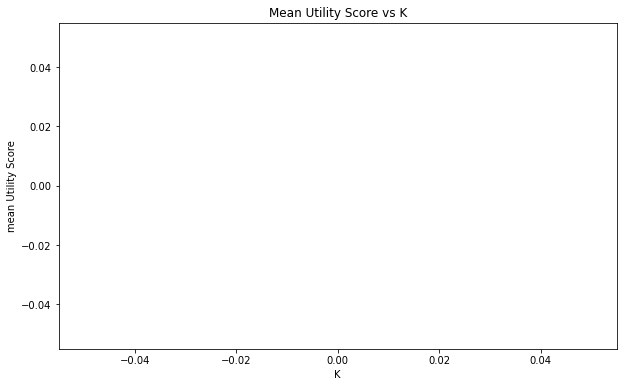

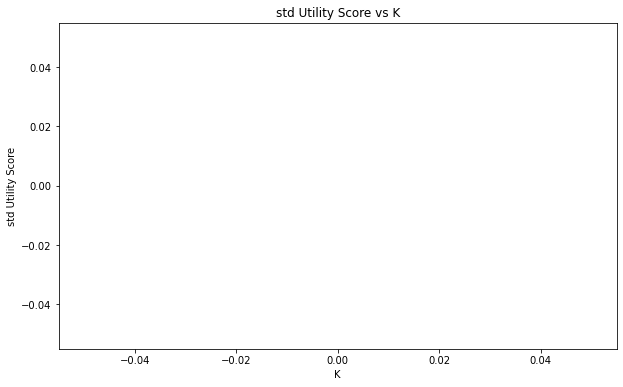

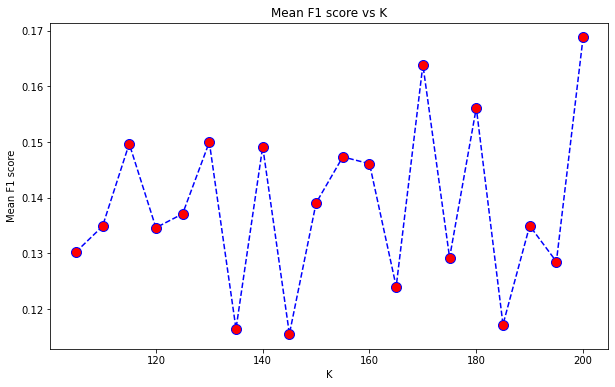

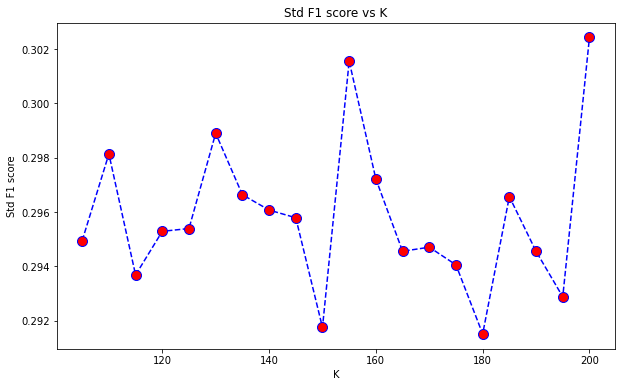

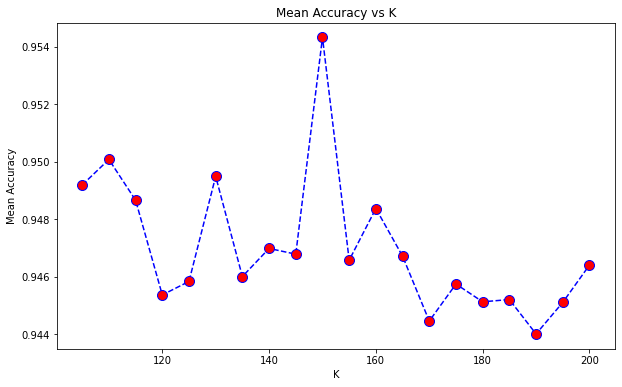

In [19]:
findBestKforKNN(XGBoostModel,10,105,200)

In [20]:
Print_DATA()

KNN_UtilityScore_mean [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
KNN_UtilityScore_std [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
KNN_F1Score_mean [0.13024, 0.13487, 0.1497, 0.13462000000000002, 0.13711, 0.14998999999999998, 0.11646000000000001, 0.14917, 0.11554, 0.13906000000000002, 0.14733999999999997, 0.14611000000000002, 0.12405, 0.16386, 0.12924, 0.15615, 0.11723000000000001, 0.13496999999999998, 0.12853, 0.16878]
KNN_F1Score_std [0.2949477452024341, 0.29813774014706695, 0.29368413644594427, 0.29528932523882406, 0.2953936304323436, 0.2989000951823201, 0.29663778316323763, 0.29607328839326247, 0.2957896286214241, 0.2917506682083179, 0.3015543042305979, 0.29721500450010935, 0.294555571157634, 0.29470557918030665, 0.2940560973691924, 0.29151098864365305, 0.29656499473134046, 0.2945527594506627, 0.2928791288227961, 0.3024264499014595]
KNN_auroc_mean [0.62683, 0.5984, 0.58

KNN of K =  265
K Fold of  10  folds with KNN = 265
for the 1 th iteration [211 275 153 189 184 110 124  49 345  73 284  20  71 328 136 241 171 141
 329 204 157 290 305 281 323  57 208  41 366 220 120 118 244  22 325 222
 178 369 381  52]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1535, 1) 1´s in y_test SepsisLabel    48.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 106.85 sec.

******************************************************************
for the 2 th iteration [ 50 379 363 326 248 348 169 319 149 210 113  77 352 342 292 324 309 285
 310  32 320 332 331 144 223 151  69 216 321 276 102 249 283  46  38 245
 376  61 289 146]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1668, 1) 1´s in y_test SepsisLabel    16.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  179
Time spent in this KFold iteration 100.66 sec.

*********************************

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1882, 1) 1´s in y_test SepsisLabel    30.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  380
Time spent in this KFold iteration 78.24 sec.

******************************************************************
for the 7 th iteration [181 308 384 103 194  68 231  12 190 155 197 142 115  79   8 306 173 147
  58 177   3 374  78 127  23 198   1  95  81  66 131 192  11  21 378  35
  59  43 361 338]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1547, 1) 1´s in y_test SepsisLabel    28.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  9
Time spent in this KFold iteration 81.8 sec.

******************************************************************
for the 8 th iteration [358 354 394  30  17 368 387 108 126 137 357 268 299 117 140  26 295  31
  55  98   5 175  39 188 263 335 107 160 209 302 260 266 288 259 156 159
 246 375 316  86]
X_train or X_test con

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1535, 1) 1´s in y_test SepsisLabel    48.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 128.69 sec.

******************************************************************
for the 2 th iteration [ 50 379 363 326 248 348 169 319 149 210 113  77 352 342 292 324 309 285
 310  32 320 332 331 144 223 151  69 216 321 276 102 249 283  46  38 245
 376  61 289 146]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1668, 1) 1´s in y_test SepsisLabel    16.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  156
Time spent in this KFold iteration 110.56 sec.

******************************************************************
for the 3 th iteration [ 28 360 341 278 225 273 218  90 227  16 393  45  18 230  92  51 307  74
 207 252 116  97 236 111 337 240  48   4 219 267 174 280  76 392 162  63
 385  53 255 238]
X_train or X_test 

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1882, 1) 1´s in y_test SepsisLabel    30.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  379
Time spent in this KFold iteration 94.98 sec.

******************************************************************
for the 7 th iteration [181 308 384 103 194  68 231  12 190 155 197 142 115  79   8 306 173 147
  58 177   3 374  78 127  23 198   1  95  81  66 131 192  11  21 378  35
  59  43 361 338]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1547, 1) 1´s in y_test SepsisLabel    28.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  5
Time spent in this KFold iteration 102.7 sec.

******************************************************************
for the 8 th iteration [358 354 394  30  17 368 387 108 126 137 357 268 299 117 140  26 295  31
  55  98   5 175  39 188 263 335 107 160 209 302 260 266 288 259 156 159
 246 375 316  86]
X_train or X_test co

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1535, 1) 1´s in y_test SepsisLabel    48.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  0
Time spent in this KFold iteration 97.69 sec.

******************************************************************
for the 2 th iteration [ 50 379 363 326 248 348 169 319 149 210 113  77 352 342 292 324 309 285
 310  32 320 332 331 144 223 151  69 216 321 276 102 249 283  46  38 245
 376  61 289 146]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1668, 1) 1´s in y_test SepsisLabel    16.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  178
Time spent in this KFold iteration 92.94 sec.

******************************************************************
for the 3 th iteration [ 28 360 341 278 225 273 218  90 227  16 393  45  18 230  92  51 307  74
 207 252 116  97 236 111 337 240  48   4 219 267 174 280  76 392 162  63
 385  53 255 238]
X_train or X_test co

X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1882, 1) 1´s in y_test SepsisLabel    30.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  399
Time spent in this KFold iteration 92.81 sec.

******************************************************************
for the 7 th iteration [181 308 384 103 194  68 231  12 190 155 197 142 115  79   8 306 173 147
  58 177   3 374  78 127  23 198   1  95  81  66 131 192  11  21 378  35
  59  43 361 338]
X_train or X_test contains NaN values, KNN/mean is performed.

y_test size: (1547, 1) 1´s in y_test SepsisLabel    28.0
dtype: float64
The number of 1 (SepsisLabel) in this prediction:  18
Time spent in this KFold iteration 99.38 sec.

******************************************************************
for the 8 th iteration [358 354 394  30  17 368 387 108 126 137 357 268 299 117 140  26 295  31
  55  98   5 175  39 188 263 335 107 160 209 302 260 266 288 259 156 159
 246 375 316  86]
X_train or X_test c

ValueError: x and y must have same first dimension, but have shapes (24,) and (8,)

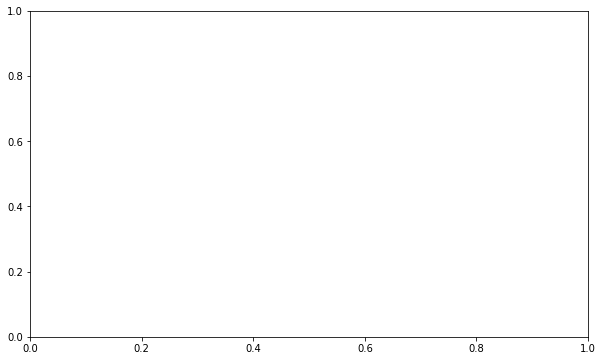

In [33]:
findBestKforKNN(XGBoostModel,10,265,380,15)

In [34]:
Print_DATA()

KNN_UtilityScore_mean [0.06700000000000002, 0.08414999999999999, 0.07633999999999999, 0.05464, 0.06975, 0.0698, 0.10788, 0.06794999999999998]
KNN_UtilityScore_std [0.11316161893504353, 0.10075073448863783, 0.09799816528894814, 0.0914671000961548, 0.08498083607496458, 0.1523134268539711, 0.1509247945170044, 0.06994726942490322]
KNN_F1Score_mean [0.07803, 0.08403000000000001, 0.08694, 0.06117, 0.08567, 0.08107, 0.11998, 0.09895]
KNN_F1Score_std [0.13669474788740058, 0.10699233664146232, 0.1319256851412946, 0.13672013787295564, 0.1185816937811229, 0.1692922033054092, 0.18141221458325232, 0.1123178992859108]
KNN_auroc_mean [0.7531899999999999, 0.77378, 0.77498, 0.78939, 0.7866299999999999, 0.7964800000000001, 0.7866, 0.77959]
KNN_auprc_mean [0.13344, 0.16433999999999999, 0.1454, 0.13903, 0.12723, 0.12964000000000003, 0.16593, 0.15159]
KNN_accuracy_mean [0.94847, 0.9501200000000001, 0.94947, 0.95617, 0.94931, 0.95014, 0.94967, 0.9484300000000001]
KNN_accuracy_std [0.05350155231392824, 0.055